In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
# For optimization using pygmo
import pygmo as pg
import numpy as np
from udp_initial_condition import udp_initial_condition
from math import pi

# For computing trajectory
from Trajectory import Trajectory

# For Plotting
import matplotlib.pyplot as plt

# For cProfile evaluation
import cProfile
import pstats

Using numpy backend


In [4]:
def setup_parameters():
    """Set up of required hyperparameters for the optimization scheme. 

    Returns:
        body_density (float): Body density of celestial body.
        body_mu (float): Gravitational parameter for celestial body.
        target_altitude (float): Squared value of the satellite's orbital target altitude.
        final_time (float): Final time for the integration of trajectory.
        start_time (float): Start time for the integration of trajectory.
        time_step (float): Size of initial time step for integration of trajectory.
        lower_bounds (np.ndarray): Lower boundary values for the initial state vector.
        upper_bounds (np.ndarray): Lower boundary values for the initial state vector.
        algorithm (int): Choice of algorithm (see file Integrator for references).
        radius_bounding_sphere (float): Radius of the bounding sphere representing risk zone for collisions with celestial body.
        population_size (int): Number of chromosomes to compare at each generation.
        number_of_generations (int): Number of generations for the genetic opimization.
    """
    # Setup hyperparameters:
    body_density = 533                  # https://sci.esa.int/web/rosetta/-/14615-comet-67p
    body_mu = 665.666                   # Gravitational parameter for 67P/C-G
    target_altitude = 8000**2           # Target altitude squared
    final_time = 20*3600.0              # Final time
    start_time = 0                      # Starting time
    time_step = 600                     # Time step size for trajectory propagation.
    radius_bounding_sphere = 5000       # Radius of the bounding sphere representing risk zone for collisions with celestial body.

    # Defining the parameter space for the optimization
    #   (Parameters are defined in osculating orbital elements)
    a = [5000, 15000] # Semi-major axis
    e = [0, 1]        # Eccentricity [0, 1]
    o = [0, 2*pi]     # Right ascension of ascending node [0,2*pi]
    w = [0, 2*pi]     # Argument of periapsis [0, 2*pi]
    i = [0, pi]       # Inclination [0, pi] 
    ea = [0, 2*pi]    # Eccentric anomaly [0, 2*pi]

    lower_bounds = np.array([a[0], e[0], i[0], o[0], w[0], ea[0]])
    upper_bounds = np.array([a[1], e[1], i[1], o[1], w[1], ea[1]])
    # Choose numerical integrator:
    algorithm = 3

    # Optimization parameters
    population_size = 10 #10
    number_of_generations = 32 #32

    return body_density, body_mu, target_altitude, final_time, start_time, time_step, lower_bounds, upper_bounds, algorithm, radius_bounding_sphere, population_size, number_of_generations

Retrieving user defined parameters...
Setting up the UDP...
Setting up the optimization algorithm...
1
2
3
4
5
6
7
8
9
10
Initializing the optimization:
11
12
13
14
15
16
17
18
19
20

   Gen:        Fevals:          Best:             F:            CR:            dx:            df:
      1             10    4.54411e+08       0.782476       0.557238          12295    2.73932e+10
21
22
23
24
25
26
27
28
29
30
      2             20    4.85612e+07       0.782476       0.557238        15100.6     2.7799e+10
31
32
33
34
35
36
37
38
39
40
      3             30    4.85612e+07       0.782476       0.557238        19714.5    2.18896e+10
41
42
43
44
45
46
47
48
49
50
      4             40    4.85612e+07       0.782476       0.557238        19476.3    1.54157e+10
51
52
53
54
55
56
57
58
59
60
      5             50    4.85612e+07       0.782476       0.557238        13845.8    1.22412e+10
61
62
63
64
65
66
67
68
69
70
      6             60    4.85612e+07       0.782476       0.557238        138

BokehModel(combine_events=True, render_bundle={'docs_json': {'51d8752e-3d12-4484-b4e4-dbd872f975e9': {'defs': …

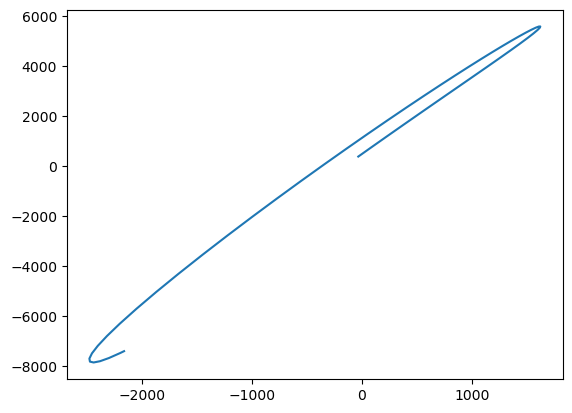

In [375]:
# Main script:

def run():
    """
    Main function for optimizing the initial state for deterministic trajectories around a 
    small celstial body using a mesh.
    """
    
    print("Retrieving user defined parameters...")
    body_density, body_mu, target_altitude, final_time, start_time, time_step, lower_bounds, upper_bounds, algorithm, radius_bounding_sphere, population_size, number_of_generations = setup_parameters()

    # Setup User-Defined Problem (UDP)
    print("Setting up the UDP...")
    udp = udp_initial_condition(body_density, body_mu, target_altitude, final_time, start_time, time_step, lower_bounds, upper_bounds, algorithm, radius_bounding_sphere)
    prob = pg.problem(udp)

    # Setup optimization algorithm
    print("Setting up the optimization algorithm...")
    algo = pg.algorithm(pg.sade(gen = number_of_generations))
    pop = pg.population(prob = prob, size = population_size)
    
    # Run optimization
    print("Initializing the optimization:")
    algo.set_verbosity(1)
    pop = algo.evolve(pop)

    # Logs for output
    print("Champion fitness value: ", pop.champion_f) 
    print("Champion chromosome: ", pop.champion_x) 

    # Retrieving champion chromosome
    x = pop.champion_x

    # Compute optimized trajectory
    trajectory = Trajectory(body_density, body_mu, final_time, start_time, time_step, algorithm, radius_bounding_sphere)
    trajectory_info, _, _  = trajectory.integrate(x)

    # Plot optimized trajectory
    trajectory.plot_trajectory(trajectory_info[0:3,:])

    plt.plot(trajectory_info[0,:],trajectory_info[1,:])

def main():
    run()

if __name__ == "__main__":
    cProfile.run("main()", "output.dat")

    with open("output_time.txt", "w") as f:
        p = pstats.Stats("output.dat", stream=f)
        p.sort_stats("time").print_stats()
    
    with open("output_calls.txt", "w") as f:
        p = pstats.Stats("output.dat", stream=f)
        p.sort_stats("calls").print_stats()
